In [708]:
import numpy as np
import pandas as pd
import ipdb
import pickle
import nnkcde
from cdetools.cdf_coverage import cdf_coverage
from cdetools.plot_utils import plot_with_uniform_band
from scipy.stats import norm, multivariate_normal
from scipy.integrate import simps
import statsmodels.api as sm
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
from scipy.special import expit, logit

import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
import seaborn as sns
from pydiffmap import diffusion_map as dm
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA

import math

import torch
import torch.nn as nn
from mdn_model import MDNPerceptron
from convolutional_mdn_model import ConvMDNPerceptron

In [ ]:
plt.style.use("default")

# specify model
## prior: $\alpha \sim Unif[-\pi,\pi],\ \ P(\lambda=0.7)=1-P(\lambda=0.1)=0.9$
## simulator: image $x$ with displacement $\lambda$, angle $a|\alpha \sim 0.5Lap(\alpha, 0.05) + 0.5Lap(\alpha, 0.0005)$

# fit convolutional MDN using PyTorch

In [129]:
with open('all_output_CMDN_2021-02-10-03-02.pkl', 'rb') as handle:
    pis, mus, sigmas = pickle.load(handle)

In [130]:
for k, pi in pis.items():
    pis[k] = pis[k].detach().numpy()

In [131]:
for k, mu in mus.items():
    mus[k] = mus[k].detach().numpy()

In [132]:
for k, sigma in sigmas.items():
    sigmas[k] = sigmas[k].detach().numpy()

In [1]:
#pis

In [2]:
#mus

In [3]:
#sigmas

# compute KL loss

In [138]:
n_train = 7000
n_val = 3000

with open('prior_mat_20210209.pkl', 'rb') as handle:
    prior_mat = pickle.load(handle)
alphas_val = prior_mat[n_train:n_train+n_val, 0]
lambdas_val = prior_mat[n_train:n_train+n_val, 1]

In [153]:
n_test = 1000
alphas_test = prior_mat[n_train+n_val : n_train+n_val+n_test, 0]
lambdas_test = prior_mat[n_train+n_val : n_train+n_val+n_test, 1]

In [139]:
def compute_neg_log_lik(alpha, pis, mus, sigmas):
    assert(pis.shape[0] == sigmas.shape[0] == mus.shape[0])
    density = 0
    for j in range(pis.shape[0]):
        density += pis[j] * norm.pdf(x=alpha, loc=mus[j], scale=sigmas[j])
    return -np.log(density)

In [141]:
NLL_dict = {}
for k in range(2,11):
    print(k)
    all_neg_log_lik = [compute_neg_log_lik(alphas_val[i], pis[k][i], mus[k][i], sigmas[k][i]) for i in range(n_val)]

    # this is the KL loss for this model on obs data (up to additive constant)
    NLL_dict[k] = 1/n_val * sum(all_neg_log_lik)

2
3
4
5
6
7
8
9
10


In [142]:
# k=9 mixture components gives the minimum KL divergence loss
pd.Series(NLL_dict)

2    -0.729225
3    -0.884834
4    -0.914971
5    -0.906613
6    -0.897189
7    -0.917310
8    -0.905574
9    -0.910777
10   -0.905177
dtype: float64

# find min-KL distribution

In [143]:
best_k = 7  # best number of mixture components according to KL loss

In [144]:
def compute_mixture_pdf(alpha, pis, sigmas, mus):
    assert(pis.shape[0] == sigmas.shape[0] == mus.shape[0])
    density = 0
    for j in range(pis.shape[0]):
        density += pis[j] * norm.pdf(x=alpha, loc=mus[j], scale=sigmas[j])
    return density

In [271]:
with open('CMDN_test_k=7_2021-02-10-16-16.pkl', 'rb') as handle:
    test_pis, test_mus, test_sigmas = pickle.load(handle)

In [277]:
test_pis = test_pis.detach().numpy()
test_mus = test_mus.detach().numpy()
test_sigmas = test_sigmas.detach().numpy()

In [278]:
# for each observed (test) data point, calc pdf value (based on out pi, mu, sigma) of theta across a theta grid
alpha_grid = np.linspace(-4, 4, 401)
# nested list comprehension ftw
all_pdf_values_test = np.array([[compute_mixture_pdf(alpha_grid[t],
                                 test_pis[i], test_sigmas[i], test_mus[i])
                                 for t in range(len(alpha_grid))] for i in range(len(alphas_test))])

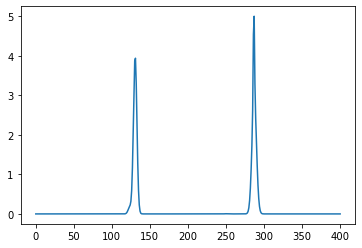

In [279]:
plt.plot(all_pdf_values_test[0])

In [280]:
den_integral = simps(all_pdf_values_test[1, :], x=alpha_grid)
print('Integral of the first density integrates to: %.2f' % den_integral)

Integral of the first density integrates to: 1.00


# compute PIT values on test data

In [281]:
# obs samples (theta,x) from joint distribution --> theta as obs posterior sample given x
pit_values = cdf_coverage(all_pdf_values_test, alpha_grid, alphas_test)

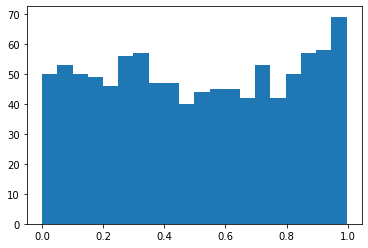

In [285]:
plt.hist(pit_values, bins=20)
plt.show()

In [286]:
pit_values_dict = {'k=7': pit_values}

In [170]:
with open('galaxies_test_20210210.pkl', 'rb') as handle:
    galaxies_test = pickle.load(handle)

In [171]:
galsim_test = galaxies_test.reshape(1000, 400)

# saved $\hat r$ from MC samples, to build CIs

In [532]:
with open("GalSim_all_rhat_classifiers_2021-02-08-02-49.pkl", 'rb') as handle:
    all_rhat_classifiers = pickle.load(handle)

C:\Users\dzhao\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\dzhao\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [542]:
def get_confidence_band_range(n_trials=1000, name='XZ', alpha=0.1, points=[[1,2]], q=0.05):
    sample = [all_rhat_classifiers[i][name][alpha].predict_proba(points)[:, 1][0] for i in range(n_trials)]
    return [np.quantile(sample, q=q), np.quantile(sample, q=1-q)]

# fixed $\mathbf{x}_i$, QQ plot of $\hat r_\alpha(\mathbf{x}_i)$ vs. $\alpha$

In [290]:
lambdas_test

array([0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.1, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.1, 0.7, 0.7, 0.1, 0.7, 0.7, 0.7, 0.7, 0.7, 0.1, 0.1,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.1, 0.7, 0.7, 0.7, 0.7, 0.1, 0.7, 0.1, 0.7, 0.7,
       0.7, 0.1, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.1, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.1, 0.7, 0.1, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.1, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.1, 0.1, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.1, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.

In [846]:
points = galsim_test[(0,2,3,4,6,12,-4,-6,991),]

In [847]:
alphas = np.linspace(0.01, 0.99, 99)

In [848]:
rhat_alphas_xi = {}
for name, pit in pit_values_dict.items():
    print("working on classifier %s" % name)
    rhat_alphas_xi[name] = {}
    for alpha in alphas:
        print(alpha)
        ind_values = [1*(x<=alpha) for x in pit]
        rhat = MLPClassifier(alpha=0, max_iter=25000)
        rhat.fit(X=galsim_test, y=ind_values)
        rhat_alphas_xi[name][alpha] = rhat.predict_proba(points)[:, 1]

working on classifier k=7
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.9600000000000001
0.97
0.98
0.99


In [575]:
confidence_qqplot = {}
confidence_qqplot['k=7'] = np.array([get_confidence_band_range(name='k=9', alpha=i, points=points)
                                     for i in np.linspace(0.1,0.9,9)])
confidence_qqplot['lambda=0.1'] = np.array([get_confidence_band_range(name='k=9', alpha=i, points=[galsim_test[-4]])
                                     for i in np.linspace(0.1,0.9,9)])
confidence_qqplot['lambda=0.7'] = np.array([get_confidence_band_range(name='k=9', alpha=i, points=[galsim_test[0]])
                                     for i in np.linspace(0.1,0.9,9)])

In [603]:
use_conf_qq = np.vstack([[0.004, 0.008], confidence_qqplot['k=7'], [0.975, 0.999]])
use_conf_qq

array([[0.004     , 0.008     ],
       [0.08268801, 0.12058409],
       [0.17392044, 0.22581947],
       [0.26954152, 0.32805185],
       [0.36874076, 0.42906591],
       [0.46851999, 0.53041181],
       [0.57078297, 0.63088121],
       [0.6696187 , 0.73097859],
       [0.77048947, 0.82580057],
       [0.8771998 , 0.91569286],
       [0.975     , 0.999     ]])

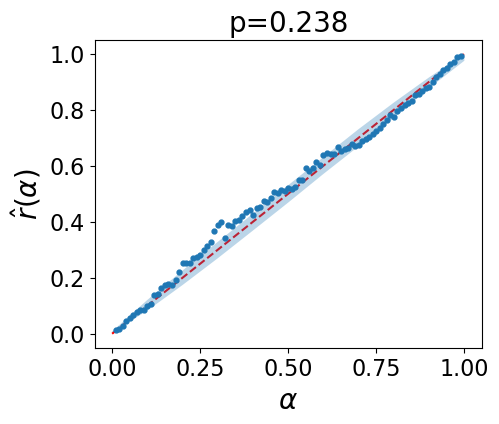

In [871]:
use_series = pd.DataFrame(rhat_alphas_xi['k=7']).T[1]

#plt.style.use("dark_background")
plt.style.use("default")
use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=1, zorder=0)

# confidence bands
plt.fill_between(np.linspace(0,1,11),
                 use_conf_qq[:, 0],
                 use_conf_qq[:, 1],
                 alpha=0.3
                )

plt.title("p=0.238", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

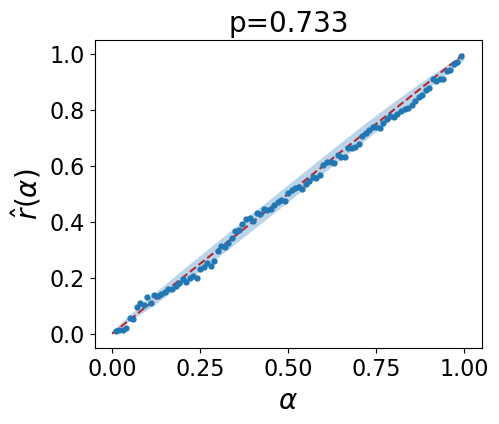

In [870]:
use_series = pd.DataFrame(rhat_alphas_xi['k=7']).T[5]

#plt.style.use("dark_background")
plt.style.use("default")
use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=1, zorder=0)

# confidence bands
plt.fill_between(np.linspace(0,1,11),
                 use_conf_qq[:, 0],
                 use_conf_qq[:, 1],
                 alpha=0.3
                )

plt.title("p=0.733", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

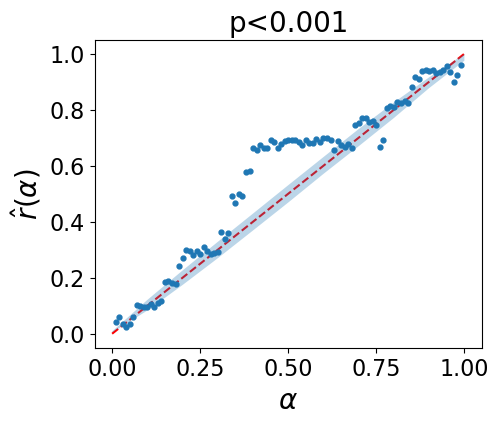

In [869]:
use_series = pd.DataFrame(rhat_alphas_xi['k=7']).T[6]

#plt.style.use("dark_background")
plt.style.use("default")
use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=1, zorder=0)

# confidence bands
plt.fill_between(np.linspace(0,1,11),
                 use_conf_qq[:, 0],
                 use_conf_qq[:, 1],
                 alpha=0.3
                )

plt.title("p<0.001", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

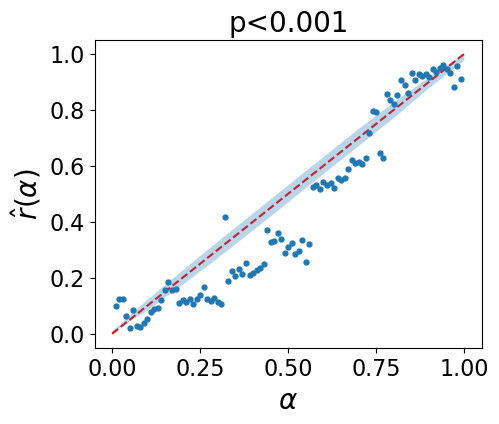

In [868]:
use_series = pd.DataFrame(rhat_alphas_xi['k=7']).T[7]

#plt.style.use("dark_background")
plt.style.use("default")
use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=1, zorder=0)

# confidence bands
plt.fill_between(np.linspace(0,1,11),
                 use_conf_qq[:, 0],
                 use_conf_qq[:, 1],
                 alpha=0.3
                )

plt.title("p<0.001", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

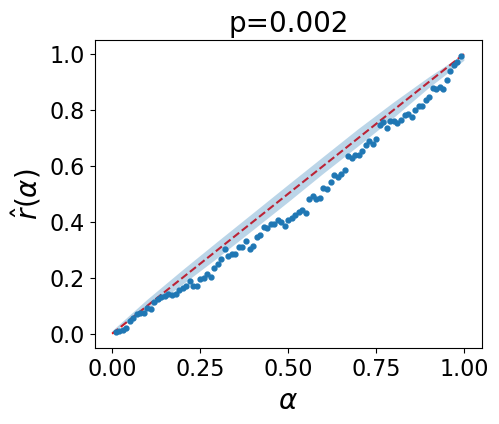

In [867]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches': 'tight'}

use_series = pd.DataFrame(rhat_alphas_xi['k=7']).T[8]

#plt.style.use("dark_background")
plt.style.use("default")
use_series.plot(style='.', figsize=(5,4), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=1, zorder=0)

# confidence bands
plt.fill_between(np.linspace(0,1,11),
                 use_conf_qq[:, 0],
                 use_conf_qq[:, 1],
                 alpha=0.3
                )

plt.title("p=0.002", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

# $T_i = \frac{1}{|G|} \sum_{\alpha \in G} (\hat r_\alpha(\mathbf{x}_i) - \alpha)^2$

In [509]:
with open('GalSim_Ti_values_2021-02-10-23-50.pkl', 'rb') as handle:
    Ti_values = pickle.load(handle)
with open('GalSim_all_rhat_alphas_2021-02-10-23-50.pkl', 'rb') as handle:
    all_rhat_alphas = pickle.load(handle)

# global p-value based on $T_i$

In [510]:
with open("GalSim_all_unif_Ti_values_2021-02-11-04-32.pkl", 'rb') as handle:
    all_unif_Ti_values = pickle.load(handle)

In [511]:
global_pvalues = sum([1* (pd.DataFrame(Ti_values).mean() < pd.DataFrame(all_unif_Ti_values[i]).mean())
                   for i in range(len(all_unif_Ti_values))]) / len(all_unif_Ti_values)
global_pvalues

k=7    0.0
dtype: float64

# local p-values based on $T_i$: local CvM test

In [ ]:
all_rhat_classifiers[0]['k=7']

In [48]:
all_rhat_classifiers[0]['k=7'][0.5].predict_proba([galsim_test[0]])

array([[0.5191299, 0.4808701]])

In [49]:
all_rhat_classifiers[0]['k=7'][0.5].predict_proba([galsim_test[-2]])

array([[0.45222516, 0.54777484]])

In [404]:
galsim_test.shape

(1000, 400)

In [512]:
all_pvalues = sum([1* (pd.DataFrame(Ti_values) < pd.DataFrame(all_unif_Ti_values[i]))
                   for i in range(len(all_unif_Ti_values))]) / len(all_unif_Ti_values)
all_pvalues

,k=7
0,0.005
1,0.085
2,0.238
3,0.659
4,0.184
...,...
995,0.779
996,0.001
997,0.356
998,0.002


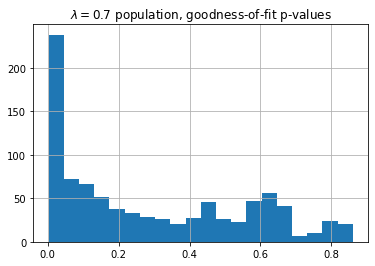

In [513]:
all_pvalues[lambdas_test == 0.7].hist(bins=20)
plt.title('$\lambda=0.7$ population, goodness-of-fit p-values')
plt.show()

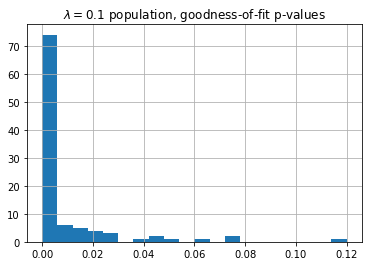

In [677]:
all_pvalues[lambdas_test == 0.1].hist(bins=20)
plt.title('$\lambda=0.1$ population, goodness-of-fit p-values')
plt.show()

# MDS

In [719]:
PCA_model = PCA(n_components=2)
PCA_model.fit(galsim_test)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [720]:
PCA_galsim_test = PCA_model.transform(galsim_test)

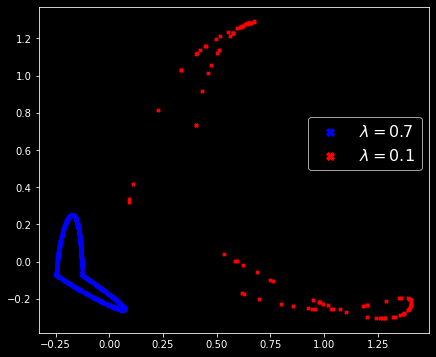

In [772]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))
plt.scatter(PCA_galsim_test[lambdas_test == 0.7][:, 0], PCA_galsim_test[lambdas_test == 0.7][:, 1], marker='X', s=10, color='blue', label='$\lambda=0.7$')
plt.scatter(PCA_galsim_test[lambdas_test == 0.1][:, 0], PCA_galsim_test[lambdas_test == 0.1][:, 1], marker='X', s=10, color='red', label='$\lambda=0.1$')


#ax.scatter(PCA_galsim_test[2][0], PCA_galsim_test[2][1], marker='*', s=150, color='white')
#ax.scatter(PCA_galsim_test[6][0], PCA_galsim_test[6][1], marker='*', s=150, color='white')
#ax.scatter(PCA_galsim_test[12][0], PCA_galsim_test[12][1], marker='*', s=150, color='white')

#ax.scatter(PCA_galsim_test[-4][0], PCA_galsim_test[-4][1], marker='*', s=150, color='white')
#ax.scatter(PCA_galsim_test[-6][0], PCA_galsim_test[-6][1], marker='*', s=150, color='white')

ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

#plt.title("PCA of GalSim, perplexity=10", fontsize=18)
ax.set_facecolor('black')
lgnd = plt.legend(fontsize=16, loc=(0.69,0.5))
lgnd.legendHandles[0]._sizes = [60]
lgnd.legendHandles[1]._sizes = [60]
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

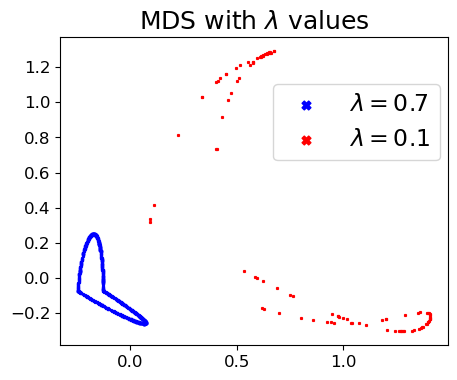

In [903]:
plt.style.use("default")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
plt.scatter(PCA_galsim_test[lambdas_test == 0.7][:, 0], PCA_galsim_test[lambdas_test == 0.7][:, 1], marker='X', s=2, color='blue', label='$\lambda=0.7$')
plt.scatter(PCA_galsim_test[lambdas_test == 0.1][:, 0], PCA_galsim_test[lambdas_test == 0.1][:, 1], marker='X', s=2, color='red', label='$\lambda=0.1$')


#ax.scatter(PCA_galsim_test[2][0], PCA_galsim_test[2][1], marker='*', s=150, color='white')
#ax.scatter(PCA_galsim_test[6][0], PCA_galsim_test[6][1], marker='*', s=150, color='white')
#ax.scatter(PCA_galsim_test[12][0], PCA_galsim_test[12][1], marker='*', s=150, color='white')

#ax.scatter(PCA_galsim_test[-4][0], PCA_galsim_test[-4][1], marker='*', s=150, color='white')
#ax.scatter(PCA_galsim_test[-6][0], PCA_galsim_test[-6][1], marker='*', s=150, color='white')

#ax.spines['bottom'].set_color('white')
#ax.spines['left'].set_color('white')

plt.title("MDS with $\lambda$ values", fontsize=18)
#ax.set_facecolor('black')
lgnd = plt.legend(fontsize=17, loc=(0.55, 0.6))
lgnd.legendHandles[0]._sizes = [40]
lgnd.legendHandles[1]._sizes = [40]
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

C:\Users\dzhao\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("crest_r"))
  import sys


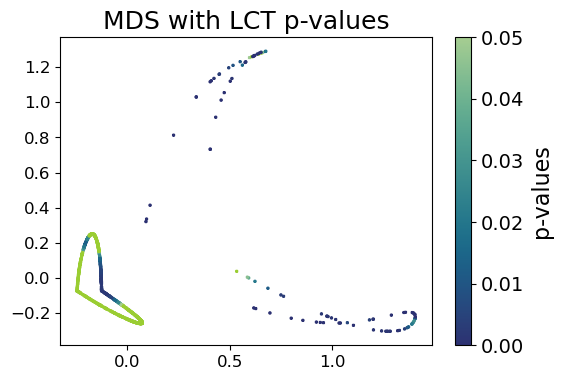

In [904]:
plt.style.use("default")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
#my_cmap = sns.light_palette("dimgray", reverse=True, as_cmap=True)
my_cmap = sns.color_palette("crest_r", as_cmap=True)
#my_cmap.set_over("white")
my_cmap.set_over("yellowgreen")
val_max = 0.05
img = plt.scatter(PCA_galsim_test[:, 0], PCA_galsim_test[:, 1], marker='X', s=2, c=all_pvalues['k=7'].values,
                  cmap=my_cmap, vmin=0, vmax=val_max)


#ax.scatter(PCA_galsim_test[2][0], PCA_galsim_test[2][1], marker='*', s=10, color='black')
#ax.scatter(PCA_galsim_test[6][0], PCA_galsim_test[6][1], marker='*', s=10, color='white')
#ax.scatter(PCA_galsim_test[12][0], PCA_galsim_test[12][1], marker='*', s=10, color='black')
#ax.scatter(PCA_galsim_test[991][0], PCA_galsim_test[991][1], marker='*', s=10, color='black')

#ax.scatter(PCA_galsim_test[-4][0], PCA_galsim_test[-4][1], marker='*', s=10, color='black')
#ax.scatter(PCA_galsim_test[-6][0], PCA_galsim_test[-6][1], marker='*', s=10, color='black')

#ax.spines['bottom'].set_color('white')
#ax.spines['left'].set_color('white')

cbar = fig.colorbar(img)
cbar.set_label("p-values", fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.title("MDS with LCT p-values", fontsize=18)
#ax.set_facecolor('black')
#lgnd = plt.legend(fontsize=14, loc=(0.6,0.7))
#lgnd.legendHandles[0]._sizes = [40]
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [845]:
PCA_galsim_test[991]

array([-0.12685352, -0.06177321])

In [842]:
all_pvalues[lambdas_test == 0.7]

,k=7
0,0.005
1,0.085
2,0.238
3,0.659
4,0.184
...,...
991,0.002
995,0.779
997,0.356
998,0.002


# GalSim image examples

In [748]:
with open('galaxy_viz_images.pkl', 'rb') as handle:
    big_imgs = pickle.load(handle)

In [738]:
# p=0.238
PCA_galsim_test[2]

array([-0.1720503 ,  0.25093616])

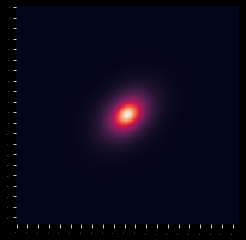

In [758]:
plt.figure(figsize=(4,4))
sns.heatmap(big_imgs[(-0.79493162, 0.7)], cbar=False)
plt.tick_params(axis='both', which='major', labelsize=0)
plt.show()

In [734]:
# p=0.329
PCA_galsim_test[6]

array([-0.23191108,  0.07772092])

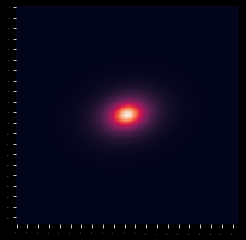

In [761]:
plt.figure(figsize=(4,4))
sns.heatmap(big_imgs[(-0.23646744, 0.7)], cbar=False)
plt.tick_params(axis='both', which='major', labelsize=0)
plt.show()

In [735]:
# p=0.733
PCA_galsim_test[12]

array([ 0.04486789, -0.21830721])

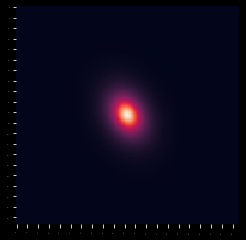

In [762]:
plt.figure(figsize=(4,4))
sns.heatmap(big_imgs[(1.14306182, 0.7)], cbar=False)
plt.tick_params(axis='both', which='major', labelsize=0)
plt.show()

In [731]:
# p < 0.001
PCA_galsim_test[-4]

array([ 0.98075993, -0.21926073])

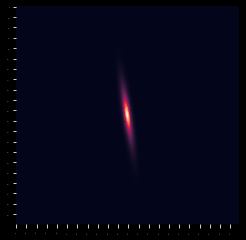

In [763]:
plt.figure(figsize=(4,4))
sns.heatmap(big_imgs[(1.42932758, 0.1)], cbar=False)
plt.tick_params(axis='both', which='major', labelsize=0)
plt.show()

In [732]:
# p<0.001
PCA_galsim_test[-6]

array([0.65331467, 1.28392502])

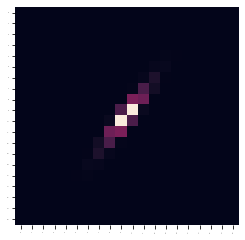

In [365]:
plt.figure(figsize=(4,4))
sns.heatmap(galsim_test[-6].reshape(20,20), cbar=False)
plt.tick_params(axis='both', which='major', labelsize=0)
plt.show()

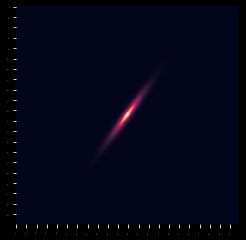

In [764]:
plt.figure(figsize=(4,4))
sns.heatmap(big_imgs[(-0.95673475, 0.1)], cbar=False)
plt.tick_params(axis='both', which='major', labelsize=0)
plt.show()

In [900]:
# IMG 991
img_991 = np.load('img_galaxy_991.npy')

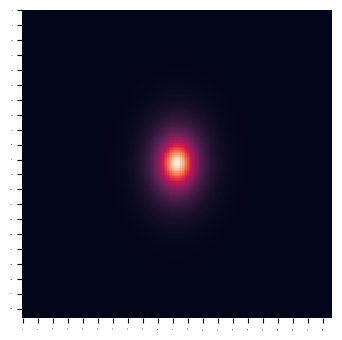

In [901]:
plt.figure(figsize=(4,4))
sns.heatmap(img_991, cbar=False)
plt.tick_params(axis='both', which='major', labelsize=0)
plt.show()

In [739]:
with open("param_mat_20210212.pkl", 'rb') as handle:
    param_mat = pickle.load(handle)

In [747]:
param_mat[[10002, 10006, 10012, 10996, 10994]]

array([[-0.79493162,  0.7       ],
       [-0.23646744,  0.7       ],
       [ 1.14306182,  0.7       ],
       [ 1.42932758,  0.1       ],
       [-0.95673475,  0.1       ]])

In [851]:
param_mat[[10991]]

array([[-1.55583905,  0.7       ]])